# Preprocessing of Mutation Frequencies
This notebook is devoted to the preprocessing of TCGA mutation frequencies. I will derive a matrix, containing the mutation frequencies per samples (columns) and genes (rows).
This matrix will later be the feature matrix used by another notebook to form a hdf5 container.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import mygene
import h5py
%matplotlib inline

## Loading high confidence MAF file

In [2]:
mutations = pd.read_csv('../data/cancer/TCGA/pancan12_cleaned.maf', sep='\t')

In [3]:
print ("Found {} samples in MAF file".format(mutations.Tumor_Sample_Barcode.nunique()))

Found 3277 samples in MAF file


## Removing Silent Mutations and Hyper-Mutated Samples

In [4]:
# remove silent mutations
non_silent = mutations[mutations.Variant_Classification != 'Silent']
print ("Removed {} (of {}) mutations because they are silent".format(mutations.shape[0]-non_silent.shape[0],
                                                                     mutations.shape[0]))

Removed 134636 (of 633377) mutations because they are silent


In [5]:
# remove ultra-mutated samples
ultra_mutators = pd.read_csv('../data/cancer/TCGA/ultramutated_tumor_ids', header=None, names=['Tumor_IDs'])
mutations_no_ultra = non_silent[~non_silent.Tumor_Sample_Barcode.isin(ultra_mutators.Tumor_IDs)]

In [6]:
mutations_no_ultra.shape, non_silent.shape
no_hyp = ultra_mutators.Tumor_IDs.nunique()
left = mutations_no_ultra.Tumor_Sample_Barcode.nunique()
print ("Left with {} samples after removing {} hyper-mutated samples".format(left, no_hyp))
print ("--> {} Mutations left".format(mutations_no_ultra.shape[0]))

Left with 3206 samples after removing 71 hyper-mutated samples
--> 315333 Mutations left


## Removing Genes with not much Gene Expression

In [7]:
# all genes in here already have more than 3 reads in more than 30% of tumors of each cancer type
ge = pd.read_csv('../data/cancer/TCGA/pancan12_rsem_matrix_tumor_type_means.tsv', sep='\t')
mutations_with_ge = mutations_no_ultra[mutations_no_ultra.Hugo_Symbol.isin(ge['#Gene'])]
no_before = mutations_no_ultra.Hugo_Symbol.nunique()
no_left = mutations_with_ge.Hugo_Symbol.nunique()
no_removed = no_before - no_left
print ("Removed {} of {} genes because of no gene expression. Left with {} genes".format(no_removed, no_before, no_left))
print ("--> {} Mutations left".format(mutations_with_ge.shape[0]))

Removed 8578 of 20294 genes because of no gene expression. Left with 11716 genes
--> 180709 Mutations left


## Creating Matrix with Samples (cols) and Genes (rows)

In [11]:
relevant_only = mutations_with_ge[['Hugo_Symbol', 'Tumor_Sample_Barcode']]
x = relevant_only.groupby(['Hugo_Symbol', 'Tumor_Sample_Barcode']).size().reset_index().rename(columns={0:'count'})
final_matrix = x.pivot(index='Hugo_Symbol', columns='Tumor_Sample_Barcode', values='count')
no_nas = final_matrix.isnull().sum().sum()
final_matrix.fillna(0, inplace=True)
print ("{} out of {} elements in matrix are 0".format(no_nas, np.prod(final_matrix.shape)))
print ("--> Only {} elements are > 0".format(np.prod(final_matrix.shape) - no_nas))

37269724 out of 37444336 elements in matrix are 0
--> Only 174612 elements are > 0


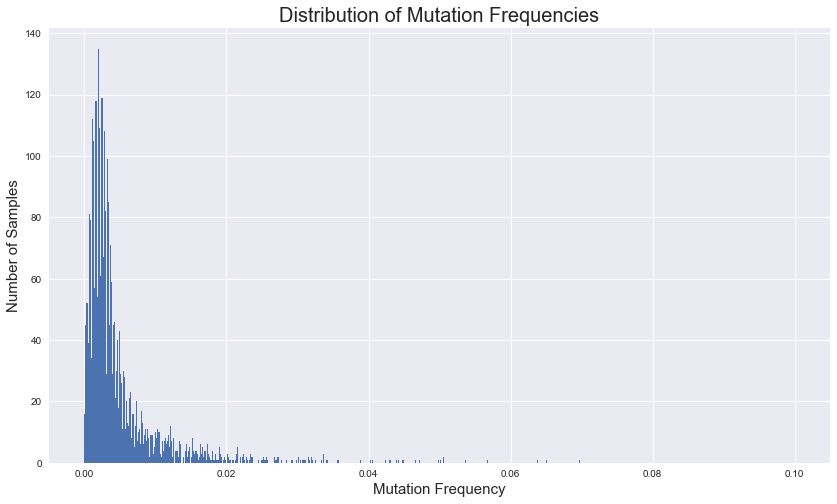

In [12]:
ax = final_matrix.mean().plot('hist', bins=np.linspace(0, .1, 700), figsize=(14, 8))
ax.set_ylabel('Number of Samples', fontsize=15)
ax.set_title('Distribution of Mutation Frequencies', fontsize=20)
ax.set_xlabel('Mutation Frequency', fontsize=15)

In [13]:
final_matrix.to_csv('../data/cancer/TCGA/mut_freqs_samples.tsv', sep='\t')

## Convert Gene Names to Ensembl IDs

In [27]:
# use mygene to get ensembl IDs from Hugo Symbols
mg = mygene.MyGeneInfo()
res = mg.querymany(final_matrix.index,
                   scopes='symbol',
                   fields='ensembl.gene, symbol',
                   species='human', returnall=True
                  )

# now, retrieve the names and IDs from a dictionary and put in DF
def get_name_and_id(x):
    ens_id = x['ensembl'][0]['gene'] if type(x['ensembl']) is list else x['ensembl']['gene']
    name = x['symbol']
    query = x['query']
    assert (name == query)
    return [ens_id, name]

ens_ids = [get_name_and_id(x) for x in res['out'] if 'ensembl' in x]
mapping = pd.DataFrame(ens_ids, columns=['Ensembl_ID', 'Name'])
mapping.set_index('Name', inplace=True)
mapping = mapping[~mapping.index.duplicated(keep='first')]

# join mutation frequencies with our derived mapping
mut_freq_sample = final_matrix.join(mapping)
print ("{} (of {}) genes had no mapping Ensembl ID".format(mut_freq_sample.Ensembl_ID.isnull().sum(),
                                                           mut_freq_sample.shape[0]))
mut_freq_sample.dropna(inplace=True) # remove unmapped genes simply

# make Ensembl ID the index and move Hugo Symbols to column
mut_freq_sample['Name'] = mut_freq_sample.index
mut_freq_sample.set_index('Ensembl_ID', inplace=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-11716...done.
Finished.
79 input query terms found dup hits:
	[('ANKRD19P', 2), ('ANKRD20A9P', 3), ('ANKRD36', 2), ('ASMTL-AS1', 2), ('BMS1P4', 2), ('C10orf25', 2
498 input query terms found no hit:
	['ABP1', 'ACN9', 'ACPL2', 'ACRC', 'ADC', 'ADCK3', 'ADCK4', 'ADRBK1', 'ADRBK2', 'AGAP8', 'AGPAT6', 'A


## Mean Across Cancer Types

In [41]:
samples_to_cancer_types = pd.read_csv('../data/cancer/TCGA/pancan12_tumor_ids.tsv', sep='\t', header=None,
                                     names=['sample', 'cancer_type'])
samples_to_cancer_types.set_index('sample', inplace=True)

In [45]:
no_names = mut_freq_sample.drop('Name', axis=1)
matrix_with_cancer_types = no_names.T.join(samples_to_cancer_types)
mean_mut_freqs = matrix_with_cancer_types.groupby('cancer_type').mean().T
mean_mut_freqs.to_csv('../data/cancer/TCGA/mean_mut_freqs_cancer_types.tsv', sep='\t')

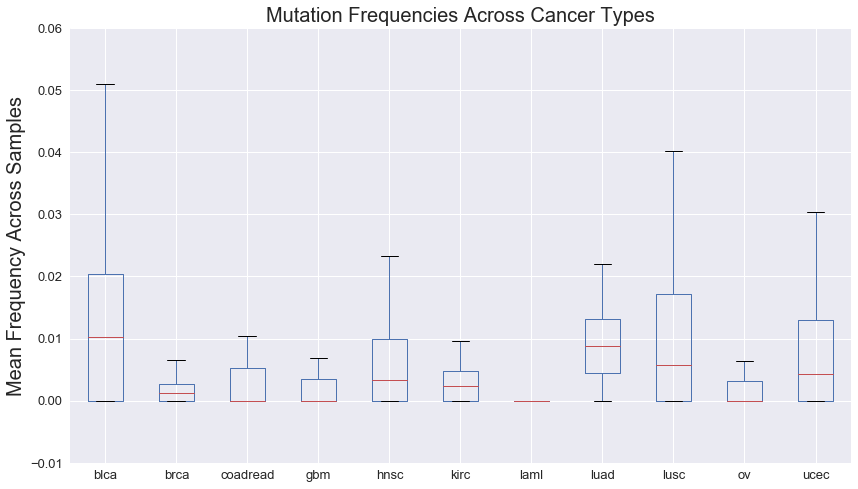

In [46]:
ax = mean_mut_freqs.plot.box(figsize=(14, 8), ylim=[-.01, .06], fontsize=13)
ax.set_ylabel('Mean Frequency Across Samples', fontsize=20)
ax.set_title('Mutation Frequencies Across Cancer Types', fontsize=20)

In [49]:
mean_mut_freqs.describe()

cancer_type,blca,brca,coadread,gbm,hnsc,kirc,laml,luad,lusc,ov,ucec
count,11217.000000,11217.000000,11217.000000,11217.000000,11217.000000,11217.000000,11217.000000,11217.000000,11217.000000,11217.000000,11217.000000
mean,0.012519,0.002295,0.004001,0.002627,0.006790,0.003175,0.000536,0.011714,0.011614,0.002511,0.008819
std,0.021653,0.006001,0.014749,0.007225,0.014415,0.007763,0.005211,0.021204,0.023742,0.009920,0.017285
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004405,0.000000,0.000000,0.000000
50%,0.010204,0.001311,0.000000,0.000000,0.003322,0.002398,0.000000,0.008811,0.005747,0.000000,0.004348
75%,0.020408,0.002621,0.005181,0.003448,0.009967,0.004796,0.000000,0.013216,0.017241,0.003165,0.013043
max,1.102041,0.369594,1.108808,0.341379,0.837209,0.561151,0.304813,1.392070,1.729885,0.955696,0.986957


## Put Feature Matrices into HDF5 Container

In [50]:
# load Container
data_file = '../data/cancer/hotnet_iref_vec_input_unbalanced.h5'

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

In [91]:
# first, bring node names to DF
nodes_df = pd.DataFrame(node_names, columns=['ensembl_id', 'name'])
nodes_df.set_index('ensembl_id', inplace=True)

# clean mutation frequencies from genes which are not in network
mutfreq_in_network = mut_freq_sample[mut_freq_sample.index.isin(nodes_df.index)]
mean_mutfreq_in_network = mean_mut_freqs[mean_mut_freqs.index.isin(nodes_df.index)]

# remove duplicates in index
mutfreq_in_network = mutfreq_in_network[~mutfreq_in_network.index.duplicated(keep='first')]
mean_mutfreq_in_network = mean_mutfreq_in_network[~mean_mutfreq_in_network.index.duplicated(keep='first')]

# build feature matrix using reindexing
features_df = mutfreq_in_network.reindex(index=nodes_df.index)
features_df_mean = mean_mutfreq_in_network.reindex(index=nodes_df.index)

num_of_zero_nodes = features_df.isnull().any(axis=1).sum()
print ("{} out of {} nodes don't have any gene expression".format(num_of_zero_nodes, network.shape[0]))
print ("--> left with valid scores for {} genes".format(network.shape[0]-num_of_zero_nodes))

# put 0 for missing data and remove name columns
features_df.fillna(0, inplace=True)
features_df.drop('Name', axis=1, inplace=True)
features_df_mean.fillna(0, inplace=True)

3725 out of 12129 nodes don't have any gene expression
--> left with valid scores for 8404 genes


In [97]:
features = features_df.as_matrix()
features_mean = features_df_mean.as_matrix()

string_dt = h5py.special_dtype(vlen=str)

# determine file name by parameters
fname = '../data/cancer/mutfreq_iref_unbalanced.h5'
f = h5py.File(fname, 'w')

# add ppi network
f.create_dataset('network', data=network, shape=network.shape)

# add features
f.create_dataset('features', data=features, shape=features.shape)
f.create_dataset('features_mean', data=features_mean, shape=features_mean.shape)

# add gene names (same order as features & network)
f.create_dataset('gene_names', data=node_names, dtype=string_dt)
# add labels
f.create_dataset('y_train', data=y_train, shape=y_train.shape)
f.create_dataset('y_test', data=y_test, shape=y_test.shape)
if y_val is not None:
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)

f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
if y_val is not None:
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
f.close()
print ("Container written to {}".format(fname))

Container written to ../data/cancer/mutfreq_iref_unbalanced.h5


In [95]:
f.close()

In [96]:
features.dtype, features_mean.dtype

(dtype('float64'), dtype('float64'))